# ENGSCI205 - Section B (Engineering Machine Learning)
## Lab 1 - Key Ideas

Welcome to your first laboratory on Engineering Machine Learning (or knowledge-/physics-informed machine learning...). The laboratory and the material provided in this notebook introduces some ideas for working with data from a physical model: the angular motion of a pendulum.

We will reproduce the lecture results. In particular, we will:
- Use scipy to simulate the angular motion of a nonlinear pendulum and construct noisy observations of this
- Use scipy to simulate the angular motion of a linear pendulum and compare this to the nonlinear pendulum
- Manually construct nearest neighbour predictions for within sample motion
- Use scikit-learn to predict at a time point within sample range  
- Test our prediction methods for time points beyond the sample range  
- Fit a simple state space model to predict beyond the sample range  

## Solve ODE

In [39]:
# import libraries for solving ode
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [40]:
# setup ODE RHS
def dydt_p(t,y,prm,is_linear=False):
    # params
    l = prm[0]
    g = prm[1]
    # vars
    theta = y[0]
    dtheta_dt = y[1]
    # ode
    # linear
    if is_linear:
      return np.array([y[1], -g/l*theta]) # ANSWER
    # nonlinear
    return np.array([y[1], -g/l*np.sin(theta)])

In [41]:
# parameters for ODE
l_true = 0.5
g_true = 9.81
prm_true = np.array((l_true,g_true))

In [42]:
print(prm_true)

[0.5  9.81]


In [43]:
# simulate

# initial condition
theta_max = np.radians(160)
y0= [theta_max,0]

# time grids
t_span=[0,10]
t_span_data=[0,6]
t_grid = np.arange(t_span[0],t_span[1],0.01)
t_data = np.arange(t_span_data[0],t_span_data[1],0.25)

# solve ODE
# note: args=[prm_true,Boolean] passes ODE arguments and a Boolean T/F for
# whether ODE is linear or not
solution_object = solve_ivp(fun=dydt_p,t_span=t_span,t_eval=t_data,
                            y0=y0,dense_output=True,rtol=1e-9,
                            args=[prm_true,False])

# extract solution at underlying time grid
sol = solution_object.sol
y_true = sol(t_grid)[0]

# extract solution at observed points and add noise
sigma = 0.1
np.random.seed(5) # set random seed for reproducibility

# ANSWER
y_data = sol(t_data)[0] + np.random.normal(loc=0,scale=sigma,size=len(t_data))

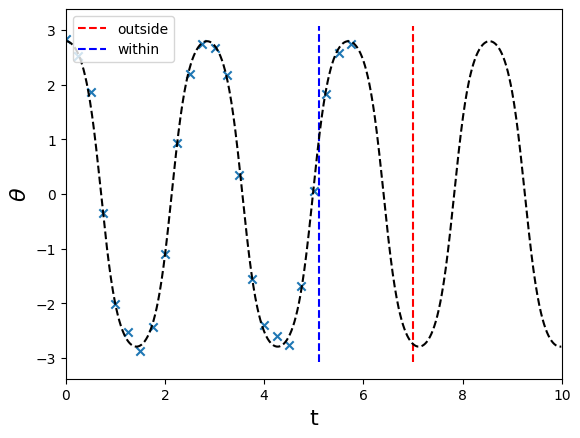

In [44]:
# plot true solution and noisy observations
plt.figure()
t_within = 5.1
t_outside = 7.0

# ANSWER
plt.vlines(x=t_outside,ymin=-1.1*theta_max,ymax=1.1*theta_max,color='r',linestyle='--',label='outside')
plt.vlines(x=t_within,ymin=-1.1*theta_max,ymax=1.1*theta_max,color='b',linestyle='--',label='within')
plt.plot(t_grid, y_true, color = 'k', linestyle = '--')
plt.scatter(t_data, y_data, marker = 'x')

plt.xlabel('t',fontsize=16)
plt.xlim(t_span)
plt.ylabel(r'$\theta$',fontsize=16)
plt.legend(loc='upper left')
plt.show()

## Update ode function to implement linear ODE option

Your task is to go back to the ODE function and implement the linear ODE option.

In [45]:
# solve linear and nonlinear cases

# nonlinear
# plot linear and nonlinear ODE solutions for comparision.
solution_object_nonlinear = solve_ivp(fun=dydt_p,t_span=t_span,t_eval=t_data,
                            y0=y0,dense_output=True,rtol=1e-9,
                            args=[prm_true,False])

# extract solution at underlying time grid
sol_nonlinear = solution_object_nonlinear.sol
y_true_nonlinear = sol_nonlinear(t_grid)[0]

# linear
# ANSWER
solution_object_linear = solve_ivp(fun=dydt_p,t_span=t_span,t_eval=t_data,
                            y0=y0,dense_output=True,rtol=1e-9,
                            args=[prm_true,True])

# extract solution at underlying time grid
sol_linear = solution_object_linear.sol
y_true_linear = sol_linear(t_grid)[0]

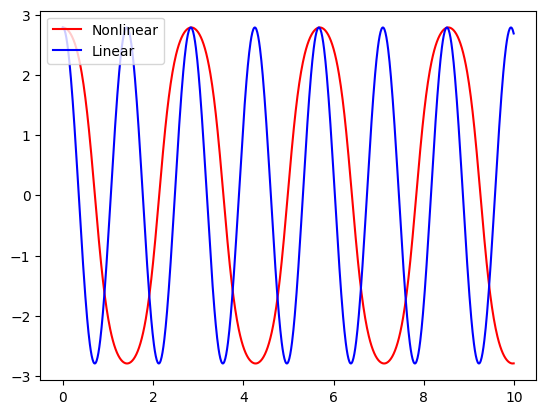

In [46]:
# plot both
plt.figure()
plt.plot(t_grid,y_true_nonlinear,'r-', label = 'Nonlinear')

#ANSWER
plt.plot(t_grid, y_true_linear, 'b-', label = 'Linear')
plt.legend(loc='upper left')

## Predict for time point within sample range

### Using nearest neighbours in time

In [47]:
# (re-) generate noisy data from nonlinear pendulum
solution_object = solve_ivp(fun=dydt_p,t_span=t_span,t_eval=t_data,
                            y0=y0,dense_output=True,rtol=1e-9,
                            args=[prm_true,False])

# extract solution at underlying time grid
sol = solution_object.sol
y_true = sol(t_grid)[0]

# extract solution at observed points and add noise
sigma = 0.1
np.random.seed(5) # set random seed for reproducibility
y_data = sol(t_data)[0] + np.random.normal(loc=0,scale=sigma,size=len(t_data))

In [48]:
# manually order the indices according of t_data array by distance to t_within value
arg_sorted = np.argsort(np.abs(t_data-t_within))

# get the indices of the two closest time points
# ANSWER
point1 = arg_sorted[0]
point2 = arg_sorted[1]

# find the index of the closest actual time point to t_within
arg_true = np.argmin(np.abs(t_grid-t_within))

k_predicted = (y_data[point1] + y_data[point2])/2

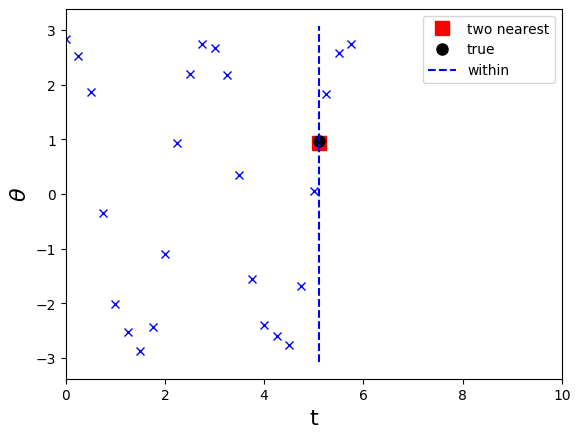

In [49]:
# plot the observed data, true new data point and predicted new data point
plt.figure()
t = np.linspace(0,10)
plt.plot(t_data,y_data,'bx')

# ANSWER
plt.plot(t_within, k_predicted, 'rs', markersize = "10", label = 'two nearest')
plt.plot(t_within, y_true[arg_true], 'ko', markersize = "8", label = 'true')
plt.vlines(x=t_within,ymin=-1.1*theta_max,ymax=1.1*theta_max,color='b',linestyle='--',label='within')

plt.xlabel('t',fontsize=16)
plt.xlim(t_span)
plt.ylabel(r'$\theta$',fontsize=16)

plt.legend()
plt.show()

### Predicting using scikit learn regression

Use method of your choice!

In [50]:
# use simple neural network here
from sklearn import neural_network # ANSWER
regr = neural_network.MLPRegressor(max_iter=5000, activation='logistic',solver='lbfgs') # ANSWER

# fit
X = t_data.reshape(-1,1)
y = y_data
regr.fit(X, y)

# find the index of the closest actual time point to last data point, t_data[-1]
arg_last = np.argmin(np.abs(t_grid-t_data[-1]))

# fitted/predicted over full time grid up to last one we have data for
y_fitted = regr.predict(t_grid[:-1].reshape(-1,1))

# predicted at new data point
y_pred = regr.predict(np.array(t_grid[arg_true]).reshape(-1,1))

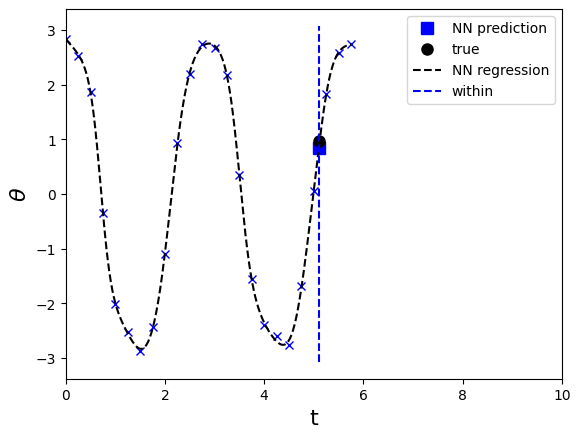

In [51]:
# plot results
plt.figure()
t = np.linspace(0,10)
plt.plot(t_data, y_data,'bx')

#ANSWER
plt.plot(t_within, y_pred, 'bs', markersize = "8", label = 'NN prediction')
plt.plot(t_within, y_true[arg_true], 'ko', markersize = "8", label = 'true')
plt.plot(t_grid[:arg_last+1], y_fitted[:arg_last+1], color='k', linestyle='--', label='NN regression')

plt.vlines(x=t_within,ymin=-1.1*theta_max,ymax=1.1*theta_max,color='b',linestyle='--',label='within')
plt.xlabel('t',fontsize=16)
plt.xlim(t_span)
plt.ylabel(r'$\theta$',fontsize=16)
plt.legend()
plt.show()

## Use above to predict out of sample for t_outside

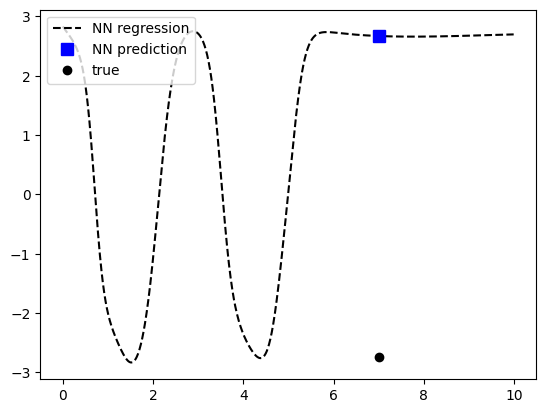

In [52]:
# fitted/predicted over full time grid up to last one we have data for
# find the index of the closest actual time point to last data point, t_data[-1]
arg_true = np.argmin(np.abs(t_grid-t_outside))
y_fitted = regr.predict(t_grid.reshape(-1,1))
y_pred = regr.predict(np.array(t_grid[:arg_true + 1]).reshape(-1,1))

# ANSWER
plt.plot(t_grid, y_fitted, color='k', linestyle='--', label='NN regression')
plt.plot(t_outside, y_pred[arg_true], 'bs', markersize = "8", label = 'NN prediction')
plt.plot(t_outside, y_true[arg_true], 'ko', label = 'true')

plt.legend(loc='upper left')
plt.show()

## Now we will use a simple autoregressive model to predict the future!

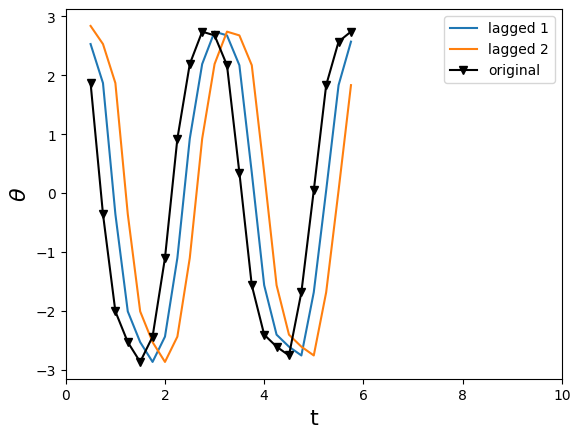

In [53]:
# create feature matrix with delay features, and target vector with first two entries dropped

#number of delays
k = 2

# target vector
y_data_target = y_data[k:]
t_data_k_on = t_data[k:]

# create lagged feature matrix
X_lagged = np.zeros((len(y_data) - k, k)) # ANSWER

for i in range(0,k):
    # roll then take from k on-wards
    X_lagged[:,i] = np.roll(y_data,i+1)[k:] # ANSWER

# plot
plt.figure()
plt.plot(t_data_k_on, X_lagged, label=['lagged 1','lagged 2'])
plt.plot(t_data_k_on,y_data_target,'-v',label='original',color='k')
plt.legend(loc='upper right')
plt.xlabel('t',fontsize=16)
plt.xlim(t_span)
plt.ylabel(r'$\theta$',fontsize=16)
plt.show()

In [54]:
# use linear regression
from sklearn import linear_model
from numpy.linalg import matrix_power

regr = linear_model.LinearRegression(fit_intercept=False)

regr.fit(X_lagged, y_data_target) # ANSWER
print(regr.coef_)

[ 1.61471777 -0.92587804]


In [55]:
# construct prediction matrix and make predictions
A = np.array([[regr.coef_[0], regr.coef_[1]], [1, 0]]) # ANSWER
dt = t_data[1]-t_data[0]
n_steps = int((t_outside-t_data[-1])/dt)

# careful to get state in correct order
state_initial = np.flip(y_data[-2:])
state_pred = matrix_power(A,n_steps)@state_initial
y_pred = state_pred[0]

In [56]:
# predict additional 10 steps ahead
n_steps_all = n_steps + 10
y_pred_all = np.zeros(n_steps_all) # ANSWER
for i in range(0,n_steps_all):
    state = matrix_power(A,i+1)@state_initial
    y_pred_all[i] = state[0]
t_pred_all = t_data[-1] + np.arange(1, n_steps_all + 1) * dt # ANSWER


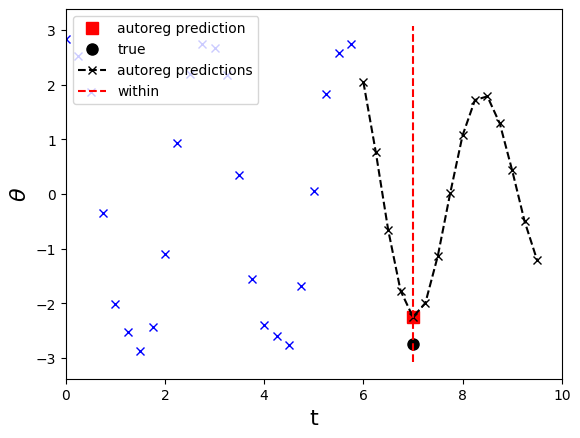

In [57]:
# plot
plt.figure()
# ANSWER
plt.plot(t_data, y_data, 'bx')
plt.plot(t_outside, y_pred, 'rs', markersize = "8", label = 'autoreg prediction')
plt.plot(t_outside, y_true[arg_true], 'ko', markersize = "8", label = 'true')
plt.plot(t_pred_all, y_pred_all, 'kx--', label='autoreg predictions')

plt.vlines(x=t_outside,ymin=-1.1*theta_max,ymax=1.1*theta_max,color='r',linestyle='--',label='within')
plt.xlabel('t',fontsize=16)
plt.xlim(t_span)
plt.ylabel(r'$\theta$',fontsize=16)
plt.legend(loc='upper left')
plt.show()